Load libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# preprocess the data
# if there is a problem pip install scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
# train the model
# problem longpath https://www.youtube.com/watch?v=uMxDjyOgLcI
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import sys
print(sys.executable)
print(sys.version)

# %matplotlib inline
import matplotlib.pyplot as plt

from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder

from aif360.sklearn.preprocessing import Reweighing, ReweighingMeta
from aif360.sklearn.inprocessing import AdversarialDebiasing
from aif360.sklearn.postprocessing import CalibratedEqualizedOdds, PostProcessingMeta
from aif360.sklearn.metrics import disparate_impact_ratio, average_odds_error, generalized_fpr
from aif360.sklearn.metrics import generalized_fnr, difference

c:\Program Files\Python312\python.exe
3.12.0 (tags/v3.12.0:0fb18b0, Oct  2 2023, 13:03:39) [MSC v.1935 64 bit (AMD64)]


pip install 'aif360[FairAdapt]'
pip install 'aif360[LFR]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'
pip install 'aif360[OptimalTransport]'


Load the data

In [2]:
df = pd.read_csv("HRDataset_v14.csv")
df.head()

,Employee_Name,EmpID,MarriedID,MaritalStatusID,GenderID,EmpStatusID,DeptID,PerfScoreID,FromDiversityJobFairID,Salary,...,ManagerName,ManagerID,RecruitmentSource,PerformanceScore,EngagementSurvey,EmpSatisfaction,SpecialProjectsCount,LastPerformanceReview_Date,DaysLateLast30,Absences
0,"Adinolfi, Wilson K",10026,0,0,1,1,5,4,0,62506,...,Michael Albert,22.0,LinkedIn,Exceeds,4.60,5,0,1/17/2019,0,1
1,"Ait Sidi, Karthikeyan",10084,1,1,1,5,3,3,0,104437,...,Simon Roup,4.0,Indeed,Fully Meets,4.96,3,6,2/24/2016,0,17
2,"Akinkuolie, Sarah",10196,1,1,0,5,5,3,0,64955,...,Kissy Sullivan,20.0,LinkedIn,Fully Meets,3.02,3,0,5/15/2012,0,3
3,"Alagbe,Trina",10088,1,1,0,1,5,3,0,64991,...,Elijiah Gray,16.0,Indeed,Fully Meets,4.84,5,0,1/3/2019,0,15
4,"Anderson, Carol",10069,0,2,0,5,5,3,0,50825,...,Webster Butler,39.0,Google Search,Fully Meets,5.00,4,0,2/1/2016,0,2


List all the variables

In [3]:
print("All variables:")
for col in df.columns:
    print("-", col)

All variables:
- Employee_Name
- EmpID
- MarriedID
- MaritalStatusID
- GenderID
- EmpStatusID
- DeptID
- PerfScoreID
- FromDiversityJobFairID
- Salary
- Termd
- PositionID
- Position
- State
- Zip
- DOB
- Sex
- MaritalDesc
- CitizenDesc
- HispanicLatino
- RaceDesc
- DateofHire
- DateofTermination
- TermReason
- EmploymentStatus
- Department
- ManagerName
- ManagerID
- RecruitmentSource
- PerformanceScore
- EngagementSurvey
- EmpSatisfaction
- SpecialProjectsCount
- LastPerformanceReview_Date
- DaysLateLast30
- Absences


Descriptive of the target / dependent variable

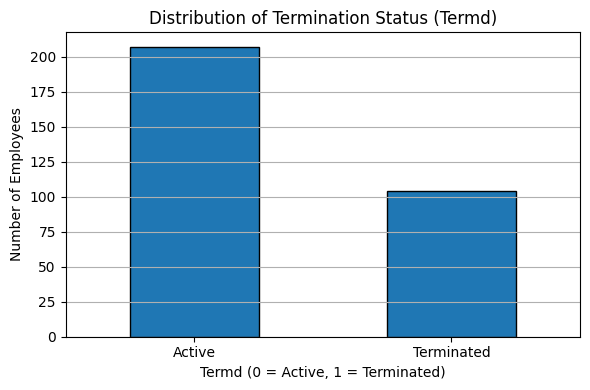

In [4]:
# Plot a bar chart for Termd values
plt.figure(figsize=(6, 4))
df['Termd'].value_counts().sort_index().plot(kind='bar', edgecolor='black')

# Add labels and title
plt.title('Distribution of Termination Status (Termd)')
plt.xlabel('Termd (0 = Active, 1 = Terminated)')
plt.ylabel('Number of Employees')
plt.xticks(ticks=[0, 1], labels=['Active', 'Terminated'], rotation=0)
plt.grid(axis='y')
plt.tight_layout()

# Show the plot
plt.show()

Clean the data

In [5]:
# Drop columns that are mostly text, IDs, or not useful for a simple model
columns_to_drop = [
    'Employee_Name', 'EmpID', 'TermReason', 'Position', 'State', 'Zip', 'DOB',
    'Sex', 'MaritalDesc', 'CitizenDesc', 'RaceDesc', 'DateofHire', 'DateofTermination',
    'EmploymentStatus', 'Department', 'ManagerName', 'RecruitmentSource',
    'PerformanceScore', 'LastPerformanceReview_Date'
]

# Drop those columns
df_clean = df.drop(columns=columns_to_drop)

# Drop rows with any missing values
df_clean = df_clean.dropna()

# Show shape and columns after cleaning
print("✅ Cleaned dataset shape:", df_clean.shape)
print("📋 Variables used:")
for col in df_clean.columns:
    print("-", col)

✅ Cleaned dataset shape: (303, 17)
📋 Variables used:
- MarriedID
- MaritalStatusID
- GenderID
- EmpStatusID
- DeptID
- PerfScoreID
- FromDiversityJobFairID
- Salary
- Termd
- PositionID
- HispanicLatino
- ManagerID
- EngagementSurvey
- EmpSatisfaction
- SpecialProjectsCount
- DaysLateLast30
- Absences


Pre process the variable

What We Do and Why:

| Task                            | What it Does                                 | Why it's Important                                |
|---------------------------------|-----------------------------------------------|---------------------------------------------------|
| 1️⃣ Separate features and target | `X = predictors`, `y = Termd`                 | We need to tell the model what to predict.        |
| 2️⃣ Encode categorical columns   | Convert text like “yes”/“no” into numbers     | Models can’t work with strings directly.          |
| 3️⃣ Scale numeric values         | Standardize to mean = 0, std = 1              | Makes training faster and more stable.            |
| 4️⃣ Split into train/test        | 80% for training, 20% for testing             | To check how well the model generalizes.          |

In [6]:
# 1️⃣ Separate features and target
X = df_clean.drop(columns='Termd')
y = df_clean['Termd']

# 2️⃣ Encode categorical columns
# (HispanicLatino is the only column with 'yes'/'no')
if X['HispanicLatino'].dtype == 'object':
    le = LabelEncoder()
    X['HispanicLatino'] = le.fit_transform(X['HispanicLatino'])

# 3️⃣ Scale numerical values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4️⃣ Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Print results
print("✅ Preprocessing complete.")
print("🔢 Training data shape:", X_train.shape)
print("🔢 Test data shape:", X_test.shape)


✅ Preprocessing complete.
🔢 Training data shape: (242, 16)
🔢 Test data shape: (61, 16)


Train the model

Now that the dataset is cleaned and preprocessed, we will train a **basic neural network using TensorFlow** to predict whether an employee will be terminated (`Termd`).

### Model Structure:
- **Input Layer**: Takes the 16 preprocessed features.
- **Hidden Layer 1**: 16 neurons with ReLU activation.
- **Hidden Layer 2**: 8 neurons with ReLU activation.
- **Output Layer**: 1 neuron with sigmoid activation (for binary classification).

### Why This Model?
This model is intentionally simple:
- ✅ It’s fast to train.
- ✅ It allows us to **observe biases** before we apply debiasing.
- ✅ It's good for initial benchmarking.

### Compilation Details:
- **Loss Function**: `binary_crossentropy` (ideal for binary classification).
- **Optimizer**: `adam` (robust default optimizer).
- **Metrics**: `accuracy` to measure correct classifications.

Once trained, the model is evaluated on the test set and its performance (accuracy) is printed.

In [7]:
# 1️⃣ Define a simple neural network
model = Sequential([
    Dense(16, activation='relu', input_shape=(X_train.shape[1],)),  # input layer
    Dense(8, activation='relu'),                                     # hidden layer
    Dense(1, activation='sigmoid')                                   # output layer (binary classification)
])

# 2️⃣ Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# 3️⃣ Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=16,
    verbose=1
)

# 4️⃣ Evaluate performance
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

c:\Program Files\Python312\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5500 - loss: 0.7164 - val_accuracy: 0.6066 - val_loss: 0.6818
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6115 - loss: 0.6721 - val_accuracy: 0.6557 - val_loss: 0.6531
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6076 - loss: 0.6597 - val_accuracy: 0.6557 - val_loss: 0.6309
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6723 - loss: 0.6241 - val_accuracy: 0.6721 - val_loss: 0.6102
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7082 - loss: 0.6176 - val_accuracy: 0.7049 - val_loss: 0.5902
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7347 - loss: 0.5655 - val_accuracy: 0.7213 - val_loss: 0.5694
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7914 - loss: 0.5297 - val_accuracy: 0.7541 - val_loss: 0.5493
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7991 - loss: 0.5217 - val_accuracy: 0.7869 - v

In [8]:
# Create AIF360 Training and Testing Datasets
import pandas as pd
from aif360.datasets import BinaryLabelDataset

# Your existing train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Step 1: Create feature names
# Assuming HispanicLatino was the only categorical column before scaling
feature_names = [f'feature_{i}' for i in range(X_train.shape[1])]

# Find HispanicLatino column index (adjust this based on your original df_clean structure)
# If HispanicLatino was in df_clean before dropping 'Termd', find its position
hispanic_index = 0  # Adjust this to match your HispanicLatino column position
feature_names[hispanic_index] = 'HispanicLatino'

print(f"\nFeature names created: {len(feature_names)} features")
print(f"HispanicLatino at index: {hispanic_index}")

# Step 2: Convert to DataFrames
X_train_df = pd.DataFrame(X_train, columns=feature_names)
X_test_df = pd.DataFrame(X_test, columns=feature_names)

# Add target column
train_df = X_train_df.copy()
train_df['Termd'] = y_train.values

test_df = X_test_df.copy()
test_df['Termd'] = y_test.values

print(f"\nDataFrames created:")
print(f"train_df shape: {train_df.shape}")
print(f"test_df shape: {test_df.shape}")

# Step 3: Create AIF360 datasets
print("\nCreating AIF360 datasets...")

# Define parameters
protected_attribute = 'HispanicLatino'
label_name = 'Termd'

# Create training dataset - name as train_360
train_360 = BinaryLabelDataset(
    favorable_label=0,                          # 0 = Not terminated (favorable)
    unfavorable_label=1,                        # 1 = Terminated (unfavorable)
    df=train_df,
    label_names=[label_name],
    protected_attribute_names=[protected_attribute]
)

# Create testing dataset - name as test_360
test_360 = BinaryLabelDataset(
    favorable_label=0,
    unfavorable_label=1,
    df=test_df,
    label_names=[label_name],
    protected_attribute_names=[protected_attribute]
)

# STEP 0: Convert underlying DataFrames
train_df, _ = train_360.convert_to_dataframe()
test_df, _ = test_360.convert_to_dataframe()

# STEP 1: Remap HispanicLatino to binary (BEFORE creating BinaryLabelDataset)
train_df['HispanicLatino'] = (train_df['HispanicLatino'] > 0).astype(int)
test_df['HispanicLatino'] = (test_df['HispanicLatino'] > 0).astype(int)

# STEP 2: Create new BinaryLabelDataset objects with proper labels and protected group
from aif360.datasets import BinaryLabelDataset

train_360 = BinaryLabelDataset(
    df=train_df,
    label_names=['Termd'],
    protected_attribute_names=['HispanicLatino'],
    favorable_label=0,  # Assuming '0' means NOT terminated (favorable)
    unfavorable_label=1
)

test_360 = BinaryLabelDataset(
    df=test_df,
    label_names=['Termd'],
    protected_attribute_names=['HispanicLatino'],
    favorable_label=0,
    unfavorable_label=1
)

# STEP 3: Apply Reweighing (NOW this works correctly)
from aif360.algorithms.preprocessing import Reweighing

reweighing = Reweighing(
    unprivileged_groups=[{'HispanicLatino': 0}],
    privileged_groups=[{'HispanicLatino': 1}]
)

train_360_reweighed = reweighing.fit_transform(train_360)

df = train_360_reweighed.convert_to_dataframe()[0]  # get underlying DataFrame
label_col = train_360_reweighed.label_names[0]
group_col = 'HispanicLatino'

# Count combinations
print(pd.crosstab(df[group_col], df[label_col]))



Feature names created: 16 features
HispanicLatino at index: 0

DataFrames created:
train_df shape: (242, 17)
test_df shape: (61, 17)

Creating AIF360 datasets...
Termd           0.0  1.0
HispanicLatino          
0.0             101   47
1.0              61   33


In [9]:
# AIF360 Debiased Logistic Regression with Bias Evaluation
from aif360.algorithms.preprocessing import Reweighing
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from sklearn.linear_model import LogisticRegression


# Step 2: Initialize regular Logistic Regression
lr_classifier = LogisticRegression(
    random_state=42,
    max_iter=1000,
    solver='liblinear'
)

print("✅ Logistic Regression initialized")

# Step 2: Define privileged and unprivileged groups for bias evaluation
privileged_groups = [{'HispanicLatino': 1}]    # Hispanic/Latino group
unprivileged_groups = [{'HispanicLatino': 0}]  # Non-Hispanic/Latino group

print(f"Privileged group (Hispanic/Latino): {privileged_groups}")
print(f"Unprivileged group (Non-Hispanic/Latino): {unprivileged_groups}")

# Step 3: Train the classifier on reweighed data
print("\nTraining logistic regression on debiased data...")

# Extract features, labels, and sample weights
X_train_reweighed = train_360_reweighed.features
y_train_reweighed = train_360_reweighed.labels.ravel()
sample_weights = train_360_reweighed.instance_weights.ravel()

# Train with sample weights (this implements the debiasing)
lr_classifier.fit(X_train_reweighed, y_train_reweighed, sample_weight=sample_weights)
print("✅ Debiased classifier trained successfully!")

# Step 4: Make predictions
print("\nMaking predictions...")
X_test = test_360.features
y_test_pred = lr_classifier.predict(X_test)


# Create prediction dataset for AIF360 metrics
predictions_360 = test_360.copy()
predictions_360.labels = y_test_pred.reshape(-1, 1)
print("✅ Predictions completed")


metric_pred = ClassificationMetric(
    test_360, predictions_360,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

print("Disparate Impact:", metric_pred.disparate_impact())


✅ Logistic Regression initialized
Privileged group (Hispanic/Latino): [{'HispanicLatino': 1}]
Unprivileged group (Non-Hispanic/Latino): [{'HispanicLatino': 0}]

Training logistic regression on debiased data...
✅ Debiased classifier trained successfully!

Making predictions...
✅ Predictions completed
Disparate Impact: 1.5011655011655012


In [10]:
from aif360.metrics import ClassificationMetric

metric_pred = ClassificationMetric(
    test_360, predictions_360,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

# Predictive performance metrics
overall_accuracy = metric_pred.accuracy()

precision = metric_pred.precision()
recall = metric_pred.recall()

print(f"Accuracy: {overall_accuracy:.3f}")
# print(f"F1 Score: {f1_score:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")

Accuracy: 0.984
Precision: 1.000
Recall: 0.973
